#Universidad Nacional De Colombia Sede Manizales

---


##Proyecto de Analitica de datos | Pr. Andres Marino Alvarez Meza

###Integrantes:
Leonar Santiago Castro Vizcaya    |    Duvan Stiven Cruz Romero    |    Juan Jose Beltran Gonzales.

#Predicción de energía renovable
Datos de: https://data.open-power-system-data.org/

Un objetivo clave de las iniciativas de redes inteligentes es aumentar significativamente la fracción de energía de la red aportada por las energías renovables. Un desafío con la integración de energías renovables en la red es que su generación de energía es intermitente e incontrolable. Por lo tanto, es importante predecir la generación renovable futura, ya que la red debe despachar generadores para satisfacer la demanda a medida que varía la generación. Este es el objetivo de nuestro proyecto. Encontrar el modelo que mejor se desempeñe el la prediccion de la generacion electrica renovable a partir de la serie de tiempo y algunas caracteristicas climaticas.

##Cargando Datos desde Drive

In [ ]:
#Librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
from pylab import *
from scipy import special, optimize
import sys
import os
pd.set_option('display.max_columns', None)

In [ ]:
#cargar datos desde drive acceso libre
#https://drive.google.com/file/d/1L_2DUvwo0ocMBaNocVi_YDuTkpWZe426/view?usp=sharing
FILEID = "1L_2DUvwo0ocMBaNocVi_YDuTkpWZe426"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2022-07-05 05:38:30--  https://docs.google.com/uc?export=download&confirm=t&id=1L_2DUvwo0ocMBaNocVi_YDuTkpWZe426
Resolving docs.google.com (docs.google.com)... 74.125.137.101, 74.125.137.113, 74.125.137.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/meavm32hkh5qd1p1qsl76tkivk61a42f/1656999450000/02377704674902172911/*/1L_2DUvwo0ocMBaNocVi_YDuTkpWZe426?e=download&uuid=e534c238-75c4-41ce-a403-46a2b0f8f93f [following]
--2022-07-05 05:38:30--  https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/meavm32hkh5qd1p1qsl76tkivk61a42f/1656999450000/02377704674902172911/*/1L_2DUvwo0ocMBaNocVi_YDuTkpWZe426?e=download&uuid=e534c238-75c4-41ce-a403-46a2b0f8f93f
Resolving doc-0o-7c-docs.googleusercontent.com (doc-0o-7c-docs.googleusercontent.com)... 142.251.2.132, 2

In [ ]:
#Rutas dataset Energias y dataset Meteorologico
filepath_prod = "/content/Bases_Prediccion_Energia_renovable/time_series_60min_singleindex.csv"
filepath_w = "/content/Bases_Prediccion_Energia_renovable/weather_data.csv"


Usaremos los datos de Alemania (DE)

In [ ]:
prod = pd.read_csv(filepath_prod, usecols=(lambda s: s.startswith('utc') | s.startswith('DE')), parse_dates=[0], index_col=0)
weather = pd.read_csv(filepath_w, parse_dates=[0], index_col=0)

##Analisis Exploratorio: Datos Alemania

Trabajamos dos modelos distintos para predecir la carga eolica y solar en funcion del clima. Por lo tanto dividimos el conjunto de datos de produccion energetica.

In [ ]:
#Produccion de Energia Eólica y  Solar (VARIABLES DE INTERES)
prod = prod[['DE_wind_generation_actual','DE_solar_generation_actual']]
prod.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


###Separamos los datos de produccion energetica Eólica y Solar

In [ ]:
wind_df = pd.DataFrame(prod['DE_wind_generation_actual'])
solar_df = pd.DataFrame(prod['DE_solar_generation_actual'])
print(wind_df.shape, solar_df.shape)

(50401, 1) (50401, 1)


Descartamos Los valores faltantes de nuestros conjunto de variables objetivo (Generacion E. Solar y Generacion E. Eólica)

In [ ]:
solar_df = solar_df.dropna()
wind_df = wind_df.dropna()

In [ ]:
print(wind_df.shape, solar_df.shape)

(50326, 1) (50297, 1)


Seleccionamos las variables de interes de nuestro conjunto de datos meteorologico. (De Alemania: Temperatura, Radiacion Horizontal Directa, Radiacion Horizontal difusa )

In [ ]:
weather = weather[[ 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']]
weather.head()

,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,
1980-01-01 00:00:00+00:00,-1.261,0.0,0.0
1980-01-01 01:00:00+00:00,-1.414,0.0,0.0
1980-01-01 02:00:00+00:00,-1.571,0.0,0.0
1980-01-01 03:00:00+00:00,-1.760,0.0,0.0
1980-01-01 04:00:00+00:00,-1.995,0.0,0.0


###Unimos el conjunto de datos meotorologicos 'wheater' a nuestro conjunto de produccion energetica y eliminamos campos vacios
'solar_df' y 'wind_df'

####Solar 

In [ ]:
solar_df = solar_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')
solar_df.head()

,DE_solar_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,
2015-01-01 07:00:00+00:00,71.0,-1.692,0.4328,6.7680
2015-01-01 08:00:00+00:00,773.0,-1.046,8.8773,51.9464
2015-01-01 09:00:00+00:00,2117.0,0.072,34.1583,97.0929
2015-01-01 10:00:00+00:00,3364.0,0.866,56.5458,120.2907
2015-01-01 11:00:00+00:00,4198.0,1.493,62.8690,126.2112


Consultamos datos vacios

In [ ]:
solar_df.isnull().sum()

DE_solar_generation_actual            0
DE_temperature                     6576
DE_radiation_direct_horizontal     6576
DE_radiation_diffuse_horizontal    6576
dtype: int64

In [ ]:
print(solar_df.shape)

(50297, 4)


Descartamos las muestras con datos nulos o vacios

In [ ]:
solar_df = solar_df.dropna()
print(solar_df.shape)

(43721, 4)


In [ ]:
solar_df.isnull().sum()

DE_solar_generation_actual         0
DE_temperature                     0
DE_radiation_direct_horizontal     0
DE_radiation_diffuse_horizontal    0
dtype: int64

#####Matriz de Correlacion Dataset Generacion Solar

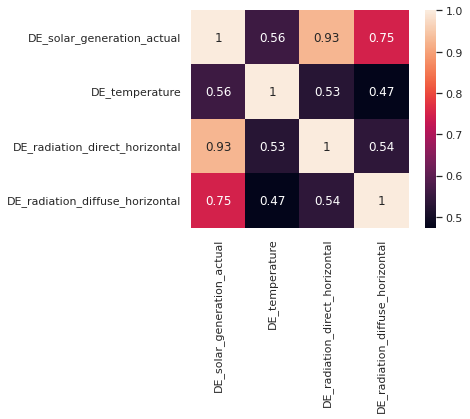

In [ ]:
sns.heatmap(solar_df.corr(),square=True, annot=True )

####Wind

In [ ]:
wind_df = wind_df.merge(weather, left_on=['utc_timestamp'], right_on=['utc_timestamp'], how='left')
wind_df.head()

,DE_wind_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,
2015-01-01 00:00:00+00:00,8852.0,-0.981,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,-1.035,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,-1.109,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,-1.166,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,-1.226,0.0,0.0


Consultamos datos vacios

In [ ]:
wind_df.isnull().sum()

DE_wind_generation_actual             0
DE_temperature                     6576
DE_radiation_direct_horizontal     6576
DE_radiation_diffuse_horizontal    6576
dtype: int64

In [ ]:
print(wind_df.shape)

(50326, 4)


Descartamos los campos vacios

In [ ]:
wind_df = wind_df.dropna()
print(wind_df.shape)

(43750, 4)


In [ ]:
wind_df.isnull().sum()

DE_wind_generation_actual          0
DE_temperature                     0
DE_radiation_direct_horizontal     0
DE_radiation_diffuse_horizontal    0
dtype: int64

#####Matriz de Correlacion Dataset - Generacion Eólica

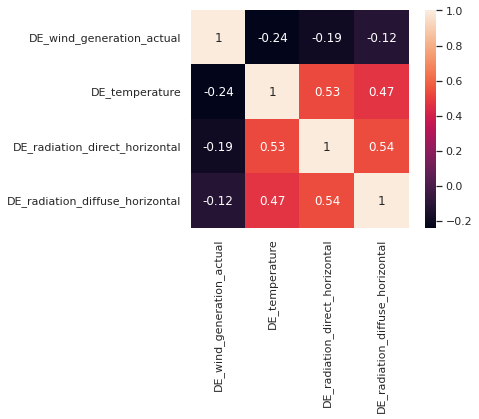

In [ ]:
sns.heatmap(wind_df.corr(),square=True, annot=True)

###Visualizacion

####Generacion de Energia Eólica

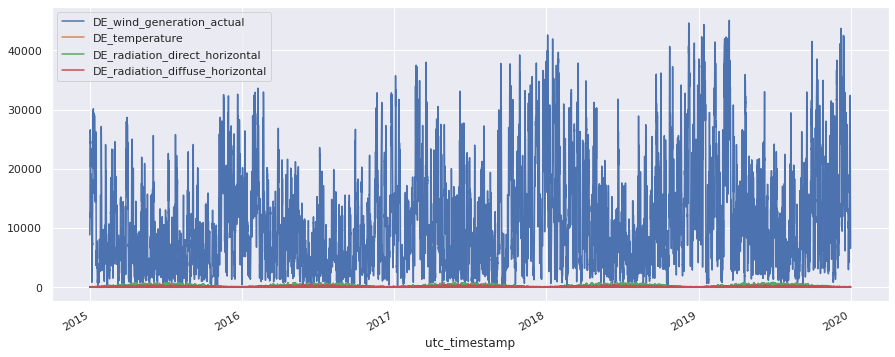

In [ ]:
wind_df.plot(figsize=(15, 6))
plt.show()

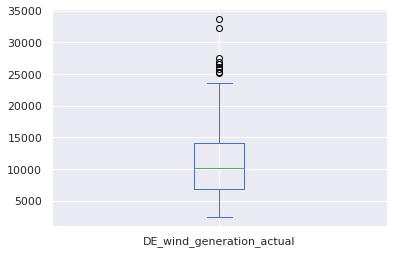

In [ ]:
ys= wind_df['DE_wind_generation_actual'].resample('w').mean()
ys.plot.box()

####Generacion de Energia Solar:

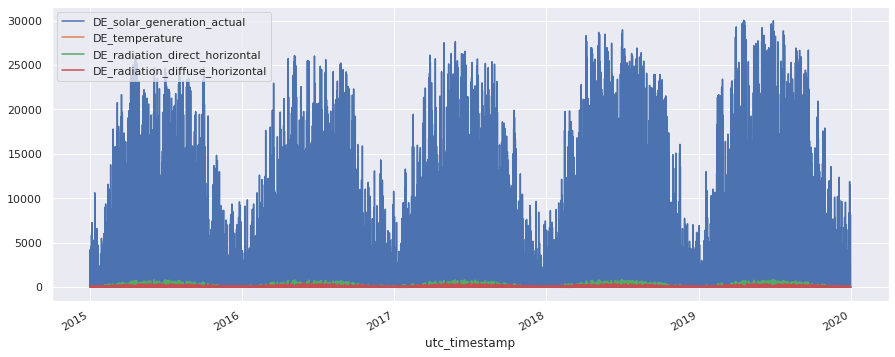

In [ ]:
solar_df.plot(figsize=(15, 6))
plt.show()

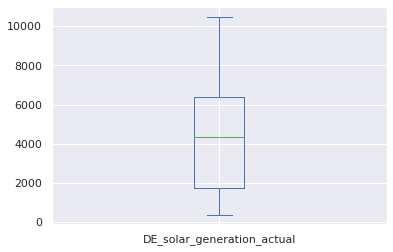

In [ ]:
y1s= solar_df['DE_solar_generation_actual'].resample('w').mean()
y1s.plot.box()
y1s.plot.box()

Existe gran variacion en la generacion eólica. Lo que puede deberse a que cada dia puede diferir mucho del siguiente en cuanto al viento, mientras que la generacion de energia solar tiene tendencias evidentes de verano en donde el sol y las altas temperaturas suelen predominar.
En la generacion solar encontramos mas variacion en general debido a que en el dia èsta varia deacuerdo a la hora y/o presencia del sol. Debido a esa elevada cantidad de datos, se tiene el grafico tan saturado.

####Atributos

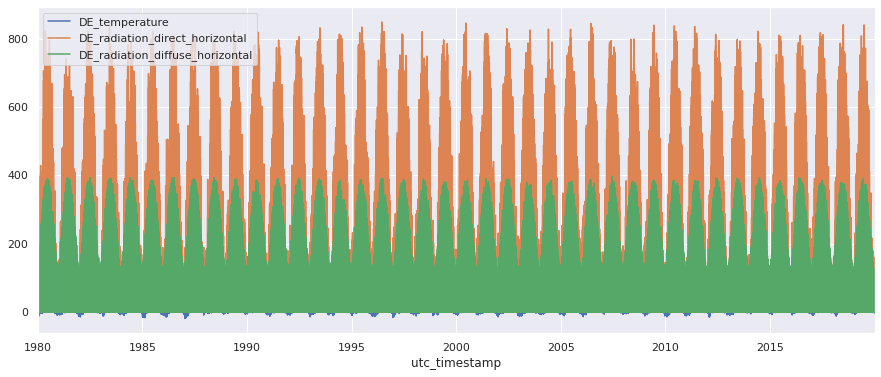

In [ ]:
weather.plot(figsize=(15, 6))#Caracteristicas Meteorologicas
plt.show()

##Preparacion

In [ ]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
# training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Emplearemos el tiempo como una variable independiente, para lo cual agregamos al final una columna con el timestamp

In [ ]:
solar_df['ds'] = solar_df.index
wind_df['ds'] = wind_df.index

In [ ]:

wind_df.head()

,DE_wind_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,ds
utc_timestamp,,,,,
2015-01-01 00:00:00+00:00,8852.0,-0.981,0.0,0.0,2015-01-01 00:00:00+00:00
2015-01-01 01:00:00+00:00,9054.0,-1.035,0.0,0.0,2015-01-01 01:00:00+00:00
2015-01-01 02:00:00+00:00,9070.0,-1.109,0.0,0.0,2015-01-01 02:00:00+00:00
2015-01-01 03:00:00+00:00,9163.0,-1.166,0.0,0.0,2015-01-01 03:00:00+00:00
2015-01-01 04:00:00+00:00,9231.0,-1.226,0.0,0.0,2015-01-01 04:00:00+00:00


Agregamos por separado los valores de Año, mes y hora

In [ ]:
solar_df['year'] = pd.DatetimeIndex(solar_df['ds']).year
solar_df['month'] = pd.DatetimeIndex(solar_df['ds']).month
solar_df['hour'] = pd.DatetimeIndex(solar_df['ds']).hour

wind_df['year'] = pd.DatetimeIndex(wind_df['ds']).year
wind_df['month'] = pd.DatetimeIndex(wind_df['ds']).month
wind_df['hour'] = pd.DatetimeIndex(wind_df['ds']).hour

In [ ]:
wind_df.head()

,DE_wind_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,ds,year,month,hour
utc_timestamp,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,-0.981,0.0,0.0,2015-01-01 00:00:00+00:00,2015,1,0
2015-01-01 01:00:00+00:00,9054.0,-1.035,0.0,0.0,2015-01-01 01:00:00+00:00,2015,1,1
2015-01-01 02:00:00+00:00,9070.0,-1.109,0.0,0.0,2015-01-01 02:00:00+00:00,2015,1,2
2015-01-01 03:00:00+00:00,9163.0,-1.166,0.0,0.0,2015-01-01 03:00:00+00:00,2015,1,3
2015-01-01 04:00:00+00:00,9231.0,-1.226,0.0,0.0,2015-01-01 04:00:00+00:00,2015,1,4


####Analisis Exploratorio: Carga media por Dia y  Mes

In [ ]:
################### Dia ##########
i=0
idx = []
for i in range(23):
 
  is_time = wind_df.loc[:, 'hour'] == i
  df_time = wind_df.loc[is_time]
  idx.append(df_time['DE_wind_generation_actual'].mean())   

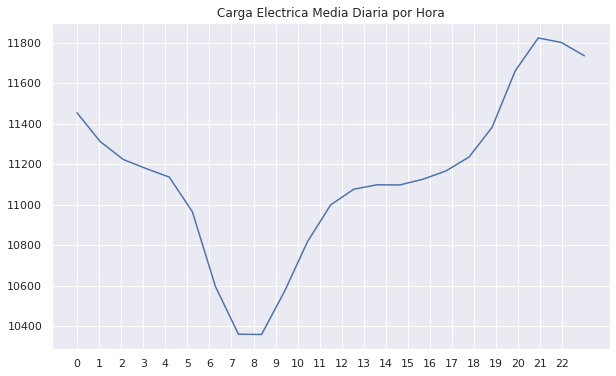

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,23,23),idx)
plt.xticks(range(0,23,1))
plt.title('Carga Electrica Media Diaria por Hora')
plt.show()

In [ ]:
########### Mes
i=1
idx = []

for i in range(12):
 
  is_time = wind_df.loc[:, 'month'] == i
  df_time = wind_df.loc[is_time]
  idx.append(df_time['DE_wind_generation_actual'].mean())

    

In [ ]:
idx= np.asarray(idx)

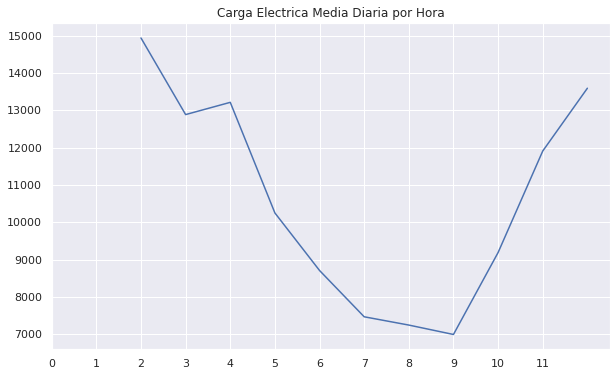

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(1,12,12),idx)
plt.xticks(range(0,12,1))
plt.title('Carga Electrica Media Diaria por Hora')
plt.show()

Codificamos los años

In [ ]:
dummy = pd.get_dummies(solar_df['year'])
dummy1 = pd.get_dummies(solar_df['month'])
dummy2 = pd.get_dummies(solar_df['hour'])

dummy3 = pd.get_dummies(wind_df['year'])
dummy4 = pd.get_dummies(wind_df['month'])
dummy5 = pd.get_dummies(wind_df['hour'])

In [ ]:
dummy.head()

,2015,2016,2017,2018,2019
utc_timestamp,,,,,
2015-01-01 07:00:00+00:00,1,0,0,0,0
2015-01-01 08:00:00+00:00,1,0,0,0,0
2015-01-01 09:00:00+00:00,1,0,0,0,0
2015-01-01 10:00:00+00:00,1,0,0,0,0
2015-01-01 11:00:00+00:00,1,0,0,0,0


Unimos los Datos

In [ ]:
solar_df = solar_df.merge(dummy, left_on='utc_timestamp', right_on='utc_timestamp')
solar_df = solar_df.merge(dummy1, left_on='utc_timestamp', right_on='utc_timestamp')
solar_df = solar_df.merge(dummy2, left_on='utc_timestamp', right_on='utc_timestamp')

wind_df = wind_df.merge(dummy3, left_on='utc_timestamp', right_on='utc_timestamp')
wind_df = wind_df.merge(dummy4, left_on='utc_timestamp', right_on='utc_timestamp')
wind_df = wind_df.merge(dummy5, left_on='utc_timestamp', right_on='utc_timestamp')

In [ ]:
solar_df.head()

,DE_solar_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,ds,year,month,hour,2015,2016,2017,2018,2019,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,0,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13,14,15,16,17,18,19,20,21,22,23
utc_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00+00:00,71.0,-1.692,0.4328,6.7680,2015-01-01 07:00:00+00:00,2015,1,7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 08:00:00+00:00,773.0,-1.046,8.8773,51.9464,2015-01-01 08:00:00+00:00,2015,1,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,2117.0,0.072,34.1583,97.0929,2015-01-01 09:00:00+00:00,2015,1,9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 10:00:00+00:00,3364.0,0.866,56.5458,120.2907,2015-01-01 10:00:00+00:00,2015,1,10,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01 11:00:00+00:00,4198.0,1.493,62.8690,126.2112,2015-01-01 11:00:00+00:00,2015,1,11,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
solar_df.shape

(43721, 49)

###Definimos Variable dependiente y Variables independientes Para REGRESOR LINEAL

In [ ]:
#Wind
X = wind_df[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
y = wind_df[['DE_wind_generation_actual']]

In [ ]:
#Solar
X1 = solar_df[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
y1 = solar_df[['DE_solar_generation_actual']]

###Creamos conjuntos Train y Test

In [ ]:
#Wind
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#Solar
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=101)

####Para definir Eje x Como dato de tiempo

In [ ]:
########## Para graficar en funcion del tiempo
#Wind
Xt_train, Xt_test= train_test_split(wind_df['ds'],  test_size=0.3, random_state=101)
#Solar
Xt1_train, Xt1_test= train_test_split(solar_df['ds'],  test_size=0.3, random_state=101)


* valor medio de generacion energetica diario



In [ ]:
#WIND
wind_media_dia = wind_df.resample('d').mean()#Data set dia
wind_media_semana = wind_df.resample('w').mean()#dataset semana
print(wind_media_dia.shape, wind_media_semana.shape)

(1826, 48) (262, 48)


In [ ]:
#SOLAR
solar_media_dia = solar_df.resample('d').mean()#Data set dia
solar_media_semana = solar_df.resample('w').mean()#dataset 
print(solar_media_dia.shape, solar_media_semana.shape)

(1826, 48) (262, 48)


###Definimos Variable dependiente y Variables independientes Para KERNEL RIDGE

In [ ]:
####### Wind
#Dia
Xd = wind_media_dia[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
yd = wind_media_dia[['DE_wind_generation_actual']]
# Semana


In [ ]:
###### Solar
#Dia
X1d = solar_media_dia[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
y1d = solar_media_dia[['DE_solar_generation_actual']]

#Semana

##Modelos Clasicos

###Linear Regression

####Wind - Generacion Eolica

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error as msa 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, Ridge, SGDRegressor, BayesianRidge

#Con standar Scaler
sca= StandardScaler()
ytrain_z= sca.fit_transform(np.array(y_train).reshape(-1,1)).reshape(-1, )
ytest_z= sca.fit_transform(np.array(y_test).reshape(-1,1)).reshape(-1, )


reg = LinearRegression().fit(X_train, ytrain_z)
y_predict_s= reg.predict(X_test)

error = msa(ytest_z, y_predict_s)
error_lineal_w_mape = mape(ytest_z, y_predict_s)
error_lineal = error

In [ ]:
#Sin Standar Scaler
reg = LinearRegression().fit(X_train, y_train)
y_predict= reg.predict(X_test)

#error=msa(y1_test, y_predic1)

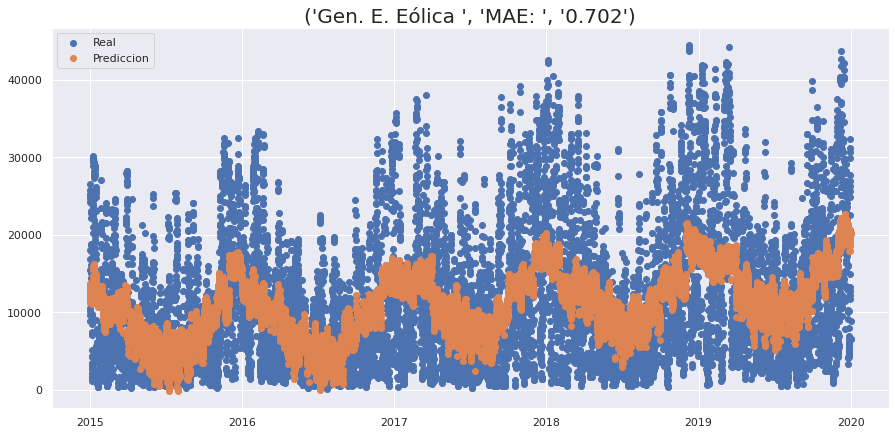

In [ ]:

plt.figure(figsize=(15,7))
plt.scatter(Xt_test, y_test, label="Real")
plt.scatter(Xt_test, y_predict, label="Prediccion")

plt.title(('Gen. E. Eólica ', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

Text(0.5, 1.0, 'Comparacion Salida Real vs salida Predecida')

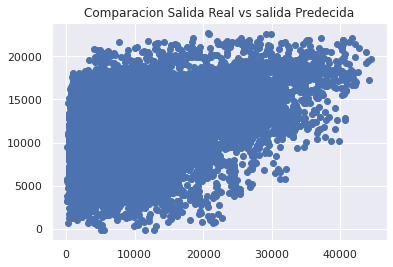

In [ ]:
plt.scatter(y_test, y_predict)
plt.title('Comparacion Salida Real vs salida Predecida')

Con un MAE de 0,69, es claro que arroja un error importante  nuestro modelo, lo que se visualiza en el  Grafico de Generacion Real y Generacion Predecida por el modelo, igualmente, al relacionar dichos conjuntos en un Scatter podemos observar que no hay una relacion lineal marcada, lo que tiene sentido teniendo en cuenta que las variables independientes que tenemos son temperatura y radiacion, condiciones climaticas que no necesariamente estan relacionadas con la Generacion Eolica como si lo podria estar el viento (Atributo climatologico del que carece nuestro data set).

####Solar - Generacion Solar

In [ ]:
#Sin Standard Scaler
reg = LinearRegression().fit(X1_train, y1_train)
y_predic1= reg.predict(X1_test)

#error=msa(y1_test, y_predic1)

In [ ]:
#Usando Standard Scaler
sca= StandardScaler()
y1train_z= sca.fit_transform(np.array(y1_train).reshape(-1,1)).reshape(-1, )
y1test_z= sca.fit_transform(np.array(y1_test).reshape(-1,1)).reshape(-1, )


reg = LinearRegression().fit(X1_train, y1train_z)
y_predic1_s= reg.predict(X1_test)

error=msa(y1test_z, y_predic1_s)
error_lineal_solar =error

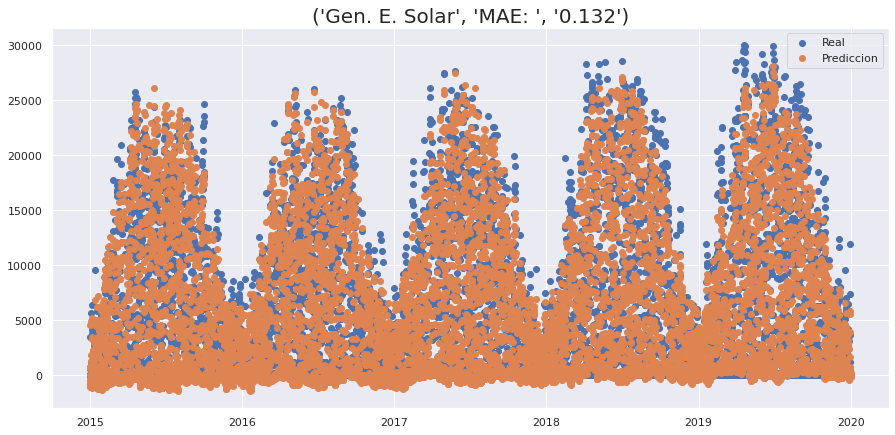

In [ ]:

plt.figure(figsize=(15,7))
plt.scatter(Xt1_test, y1_test, label="Real")
plt.scatter(Xt1_test, y_predic1, label="Prediccion")
plt.title(('Gen. E. Solar', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()



Text(0.5, 1.0, 'Comparacion Salida Real vs salida Predecida')

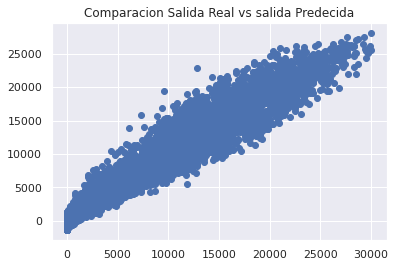

In [ ]:
plt.scatter(y1_test, y_predic1)
plt.title('Comparacion Salida Real vs salida Predecida')

Con un MAE de 0.132 y con un grafico mucho mas similar entre el conjunto de salida Real Y el predecido, el modelo para generacion energetica solar es mucho mas efectivo, lo que tiene sentido considerando que la generacion solar tiene una mayor correlacion con las variables de temperatura y radiacion solar.

###Lasso

####Wind - Generacion Eólica

In [ ]:
# Sin S_Scaler
modelLasso= Lasso(alpha=0.02).fit(X_train, y_train)
y_predict_lasso = modelLasso.predict(X_test)

# Con s_Scaler
modelLasso= Lasso(alpha=0.02).fit(X_train, ytrain_z)
y_predict_lasso_s = modelLasso.predict(X_test)

In [ ]:
Lasso_loss_w = msa(ytest_z, y_predict_lasso_s)

In [ ]:
Lasso_loss_w

0.7339399554354388

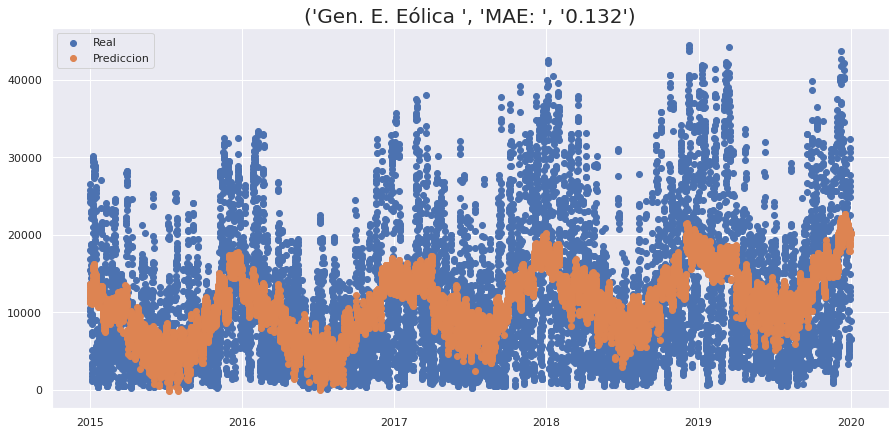

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt_test, y_test, label="Real")
plt.scatter(Xt_test, y_predict_lasso, label="Prediccion")
plt.title(('Gen. E. Eólica ', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()


####Solar - Generacion Solar

In [ ]:
### Sin S. Scaler
modelLasso= Lasso(alpha=0.02).fit(X1_train, y1_train)
y_predict_lasso = modelLasso.predict(X1_test)

### Con S. Scaler
modelLasso_s= Lasso(alpha=0.02).fit(X1_train, y1train_z)
y_predict_lasso_s = modelLasso_s.predict(X1_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.176e+08, tolerance: 1.340e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
Lasso_loss_s = msa(y1test_z, y_predict_lasso_s)

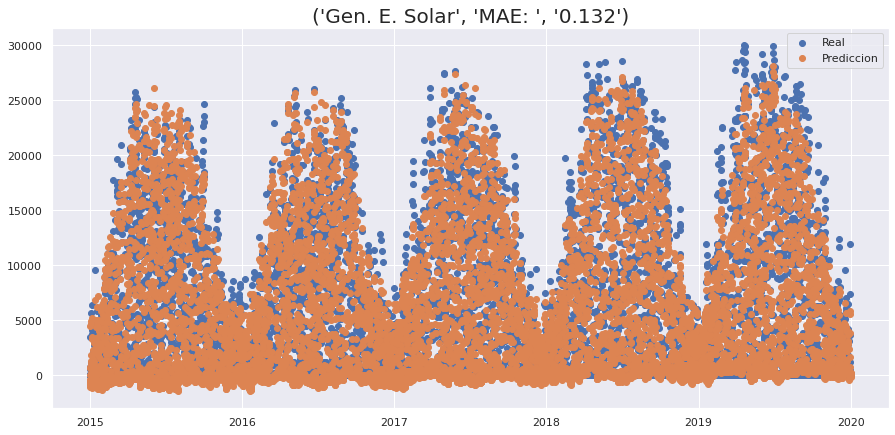

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt1_test, y1_test, label="Real")
plt.scatter(Xt1_test, y_predict_lasso, label="Prediccion")
plt.title(('Gen. E. Solar', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

###Ridge

####Wind - Generacion Eólica

In [ ]:
###Sin S_Scaler
modelRidge= Ridge(alpha=1).fit(X_train, y_train)
y_predict_Ridge = modelRidge.predict(X_test)


###Con S_Scaler
modelRidge_s= Ridge(alpha=1).fit(X_train, ytrain_z)
y_predict_Ridge_s = modelRidge_s.predict(X_test)

error=msa(ytest_z, y_predict_Ridge_s)
error_ridge_w = error

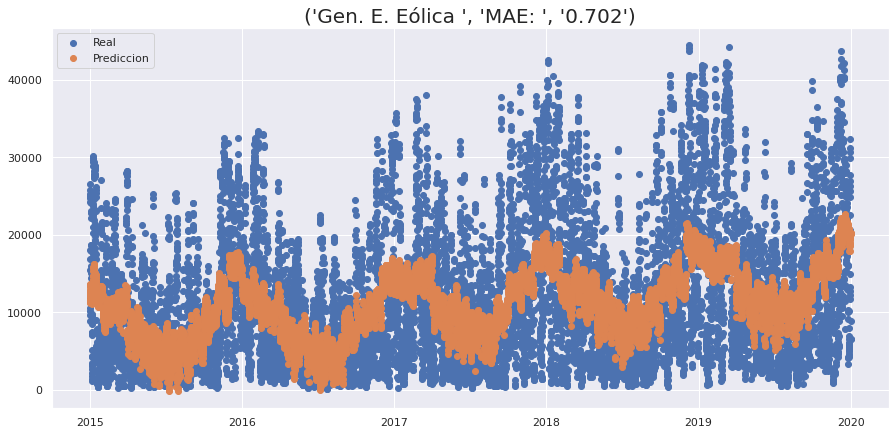

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt_test, y_test, label="Real")
plt.scatter(Xt_test, y_predict_Ridge, label="Prediccion")

plt.title(('Gen. E. Eólica ', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

#### Solar - Generacion Solar

In [ ]:
### Sin S_Scaler
modelRidge= Ridge(alpha=1).fit(X1_train, y1_train)
y_predict_Ridge = modelRidge.predict(X1_test)

### Con S_Scaler
modelRidge_s= Ridge(alpha=1).fit(X1_train, y1train_z)
y_predict_Ridge_s = modelRidge_s.predict(X1_test)

#Error
error=msa(y1test_z, y_predict_Ridge_s)
error_ridge_s =error


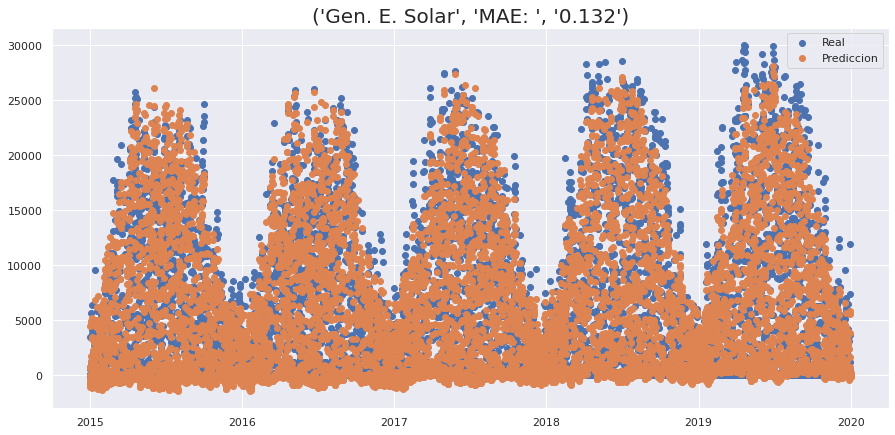

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt1_test, y1_test, label="Real")
plt.scatter(Xt1_test, y_predict_Ridge, label="Prediccion")
plt.title(('Gen. E. Solar', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

###Elastic Net

####Wind - Generacion **Eólica**

In [ ]:
###Sin Usar S_Scaler

reg = ElasticNet().fit(X_train, y_train)
y_predict= reg.predict(X_test)

###Usando S_Scaler
reg_s = ElasticNet().fit(X_train, ytrain_z)
y_predict_s= reg_s.predict(X_test)

#Error
error = msa(ytest_z, y_predict_s)
error_en_w =error

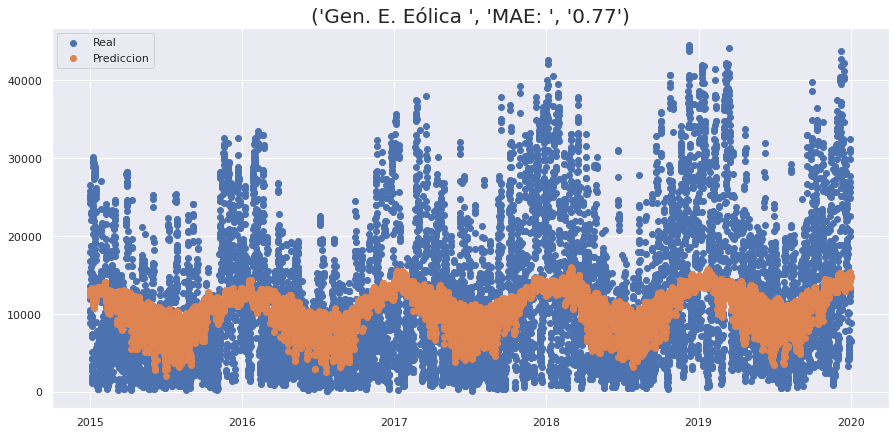

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt_test, y_test, label="Real")
plt.scatter(Xt_test, y_predict, label="Prediccion")
plt.title(('Gen. E. Eólica ', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

####Solar - Generacion Solar

In [ ]:
### Sin S_Scaler
reg = ElasticNet().fit(X1_train, y1_train)
y_predict= reg.predict(X1_test)

### Con S_SCaler
reg_s = ElasticNet().fit(X1_train, y1train_z)
y_predict_s= reg_s.predict(X1_test)

### Error
error = msa(y1test_z, y_predict_s)
error_en_s =error

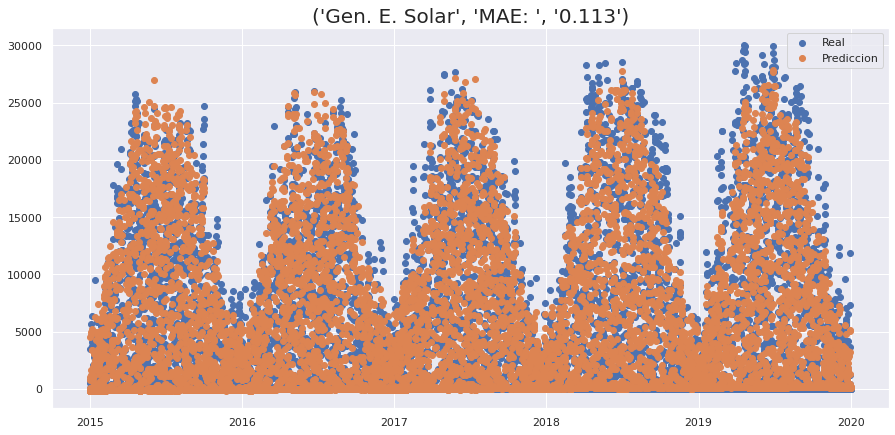

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(Xt1_test, y1_test, label="Real")
plt.scatter(Xt1_test, y_predict, label="Prediccion")
plt.title(('Gen. E. Solar', 'MAE: ', str(round(error,3))), loc = 'center', size=20)
plt.legend()

## RNN

Abordamos el pronostico de la serie: El valor actual de la serie Zt como funcion de sus valores pasados Zt-1,..., Zt-P, donde estos valores pasados seran nuestra entrada a la Red Neuronal.

Usaremos entonces la cantidad media de energia generada de manera eolica y solar de cada semana.

Se tiene entonces el valor medio de energia generado cada semana, en total 262 valores donde usamos los primeros 200 datos para especiificar el modelo y los 62 restantes para evaluar el pronostico una semana por fuera de la muetra de calibracion de los parametros.

In [ ]:
#   WIND - Valores Medios
wind_media_dia = wind_df.resample('d').mean()#Data set dia
wind_media_semana = wind_df.resample('w').mean()#dataset semanal
print(wind_media_dia.shape, wind_media_semana.shape)

(1826, 48) (262, 48)


In [ ]:
#  SOLAR - Valor medio 
solar_media_dia = solar_df.resample('d').mean()#Data set dia
solar_media_semana = solar_df.resample('w').mean()#dataset Semanal
print(solar_media_dia.shape, solar_media_semana.shape)

(1826, 48) (262, 48)


In [ ]:
####### Wind
#Dia
Xd = wind_media_dia[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
yd = wind_media_dia[['DE_wind_generation_actual']]
# Semana
ys = wind_media_semana[['DE_wind_generation_actual']]########## DATOS SEMANALES - EOLICO


In [ ]:
####### Solar
#Dia
Xd1 = solar_media_dia[['DE_temperature','DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal',2015,2016,2017,2018,2019,'1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',0,'1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y',13,14,15,16,17,18,19,20,21,22,23]] 
yd1 = solar_media_dia[['DE_solar_generation_actual']]
# Semana
ys1 = solar_media_semana[['DE_solar_generation_actual']]########## DATOS SEMANALES - SOLAR


In [ ]:
ys_array = np.asarray(ys).reshape(262,) #ARRAY - DATOS GENERACION EOLICA SEMANAL
ys1_array = np.asarray(ys1).reshape(262,) #ARRAY - DATOS GENERACION SOLAR SEMANAL

A pesar de tanta variabilidad en los datos de generacion electrica Eólioca y SolarObservamos un comportamiento un poco ciclico en el valor de la energia generada. A demas se observa una tendencia creciente en el largo pazo.

####Funcion de Auto Correlacion:

  Usualmente usada en problemas de series de tiempo ya que mide la relacion que hay entre un dato y el anterior

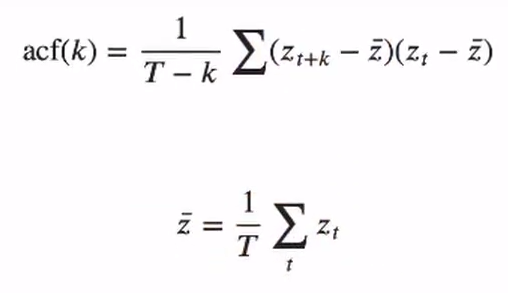

In [ ]:
import warnings
from statsmodels.tsa.stattools import acf, pacf
warnings.filterwarnings("ignore")

In [ ]:
def acf_plot(z):
  acf_data = acf(z, fft = False)
  plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
  plt.ylim(-1,1)
  plt.grid()

In [ ]:
def pacf_plot(z):
  pacf_data = pacf(z)
  plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
  plt.ylim(-1,1)
  plt.grid()

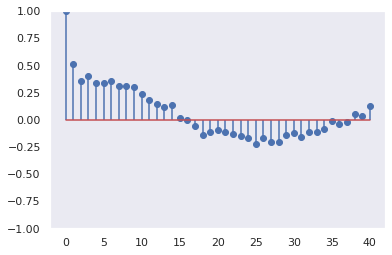

In [ ]:
acf_plot(ys) #Funcion de Correlacion Parcial; Permite extraer los retardos significativos

#### Modelo 

#####Wind - Generacion Eólica

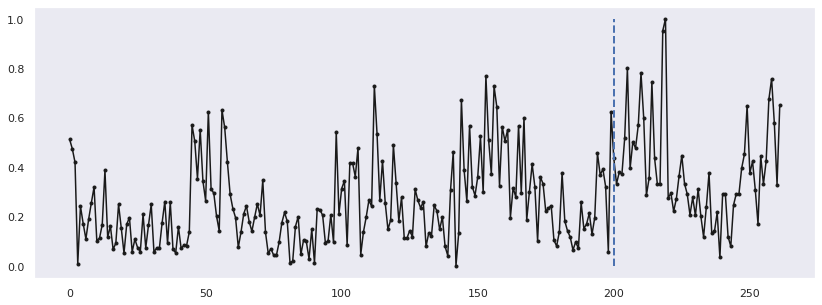

In [ ]:
#primer paso Escalamos la serie al intervalo [0,1]

scaler= MinMaxScaler() #Creamos el transformador
data_scaled = scaler.fit_transform(  np.array(ys).reshape(-1,1)  )#Esclado

#z array de listas como efecto del escalamiento
data_scaled=[u[0] for u in data_scaled]

plt.figure(figsize=(14,5))
plt.plot(data_scaled, ".-k")
plt.grid()
plt.plot(
         [len(data_scaled)-62, len(data_scaled)-62],
         [min(data_scaled), max(data_scaled)],
         "--",
         linewidth = 2 
);

Como la implementacion de Sklearn es para modelos de regresion, fue necesario crear una matriz donde las variables independientes son Z_t-1, ... Z_t-p y la variable dependiente es Zt.

In [ ]:
P = 15 # 
X=[]
for t in range(P-1, 262-1): # Para construir la matriz de regresores
  X.append([data_scaled[t-n] for n in range(P)])

observed_scaled = data_scaled[P:]



In [ ]:
#Numero total de Patrones al Convertir los datos en un modelo de regresion
len(X)

247

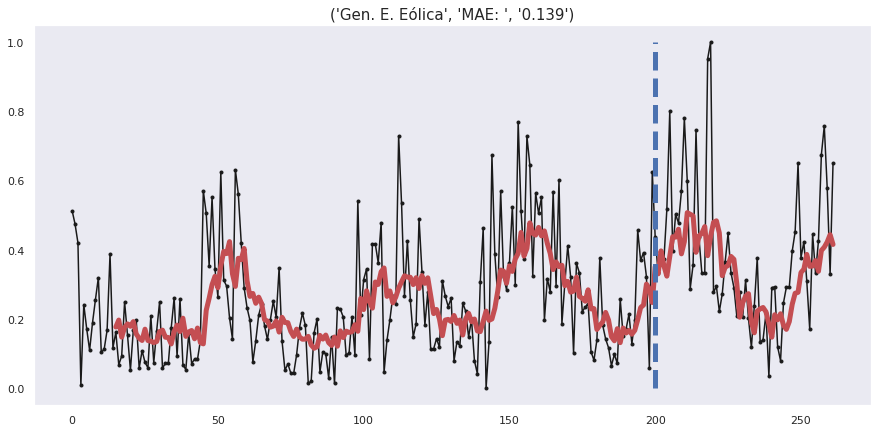

In [ ]:
from sklearn.neural_network import MLPRegressor #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
np.random.seed(101)
H = 20# Capas ocultas

mlp = MLPRegressor(
      hidden_layer_sizes=(H,),
      activation = "logistic",
      learning_rate="constant",
      momentum = 0.0,
      learning_rate_init=0.01, ## Variar
      max_iter=10000
)

#### Entrenamiento
mlp.fit(X[0:185], observed_scaled[0:185])#247- 62 = 185

#### Pronostico
y_scaled_m1 = mlp.predict(X)
#Error

error_RNN_W = msa(observed_scaled[185:262],y_scaled_m1[185:262])

plt.figure(figsize=(15,7))
plt.plot(data_scaled, ".-k")
plt.grid()

#No hay pronostico para los primeros 15 valores de la serie puesto que cada valor se calcula conb base a los 15 anteriores

plt.plot([None] * P + y_scaled_m1.tolist(), "-r",linewidth=5)




plt.title(('Gen. E. Eólica', 'MAE: ', str(round(error_RNN_W,3))), loc = 'center', size=15)

#Linea que divide los datos de entrenamiento del pronostico, se ubica el ultimo usado para entrenamiento.
plt.plot(
        [len(data_scaled) - 62, len(data_scaled)-62],
        [min(data_scaled), max(data_scaled)],
        "--",
        linewidth=5,
);

Regreso los datos a la **Escala Original**

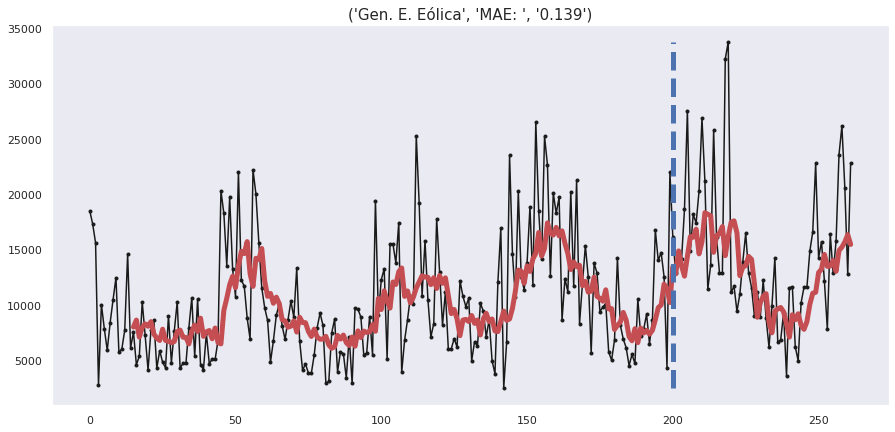

In [ ]:
y_m1 = scaler.inverse_transform([[u] for u in y_scaled_m1])
y_m1 = [u[0]for u in y_m1]

plt.figure(figsize=(15,7))
plt.title(('Gen. E. Eólica', 'MAE: ', str(round(error_RNN_W,3))), loc = 'center', size=15)
plt.plot(ys_array, ".-k")
plt.grid()
plt.plot([None]*P + y_m1, "-r", linewidth=5)
plt.plot([len(ys_array)-62, len(ys_array)-62], [min(ys_array),max(ys_array)], "--", linewidth=5)

##### Solar -Generacion de Solar

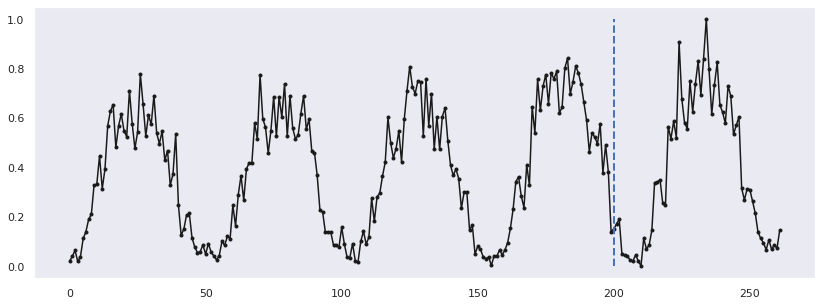

In [ ]:
#primer paso Escalamos la serie al intervalo [0,1]

scaler= MinMaxScaler() #Creamos el transformador
data_scaled = scaler.fit_transform(  np.array(ys1).reshape(-1,1)  )#Esclado

#z array de listas como efecto del escalamiento
data_scaled=[v[0] for v in data_scaled]

plt.figure(figsize=(14,5))
plt.plot(data_scaled, ".-k")
plt.grid()
plt.plot(
         [len(data_scaled)-62, len(data_scaled)-62],
         [min(data_scaled), max(data_scaled)],
         "--",
         linewidth = 2 
);

In [ ]:
P = 15 # 
X1=[]
for t in range(P-1, 262-1): # Para construir la matriz de regresores
  X1.append([data_scaled[t-n] for n in range(P)])

observed_scaled = data_scaled[P:]



In [ ]:
#Numero total de Patrones al Convertir los datos en un modelo de regresion
len(X1)

247

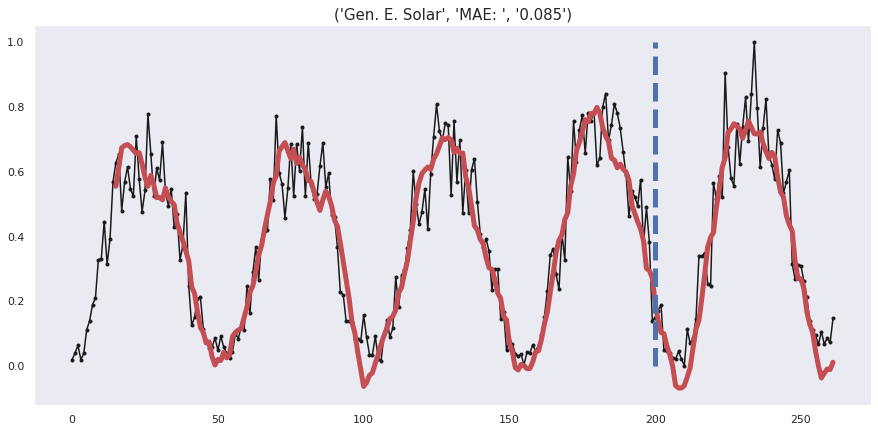

In [ ]:
from sklearn.neural_network import MLPRegressor
np.random.seed(101)
H = 20# Capas ocultas

mlp1 = MLPRegressor(
      hidden_layer_sizes=(H,),
      activation = "logistic",
      learning_rate="constant",
      momentum = 0.0,
      learning_rate_init=0.01, ## Variar
      max_iter=10000
)

#### Entrenamiento
mlp1.fit(X1[0:185], observed_scaled[0:185])#247- 62 = 185

#### Pronostico
y1_scaled_m1 = mlp1.predict(X1)


#Error
error_RNN_S = msa(observed_scaled[185:262],y1_scaled_m1[185:262])
plt.figure(figsize=(15,7))
plt.title(('Gen. E. Solar', 'MAE: ', str(round(error_RNN_S,3))), loc = 'center', size=15)
plt.plot(data_scaled, ".-k")
plt.grid()

#No hay pronostico para los primeros 15 valores de la serie puesto que cada valor se calcula conb base a los 40 anteriores

plt.plot([None] * P + y1_scaled_m1.tolist(), "-r",linewidth=5)

#Linea que divide los datos de entrenamiento del pronostico, se ubica el ultimo usado para entrenamiento.
plt.plot(
        [len(data_scaled) - 62, len(data_scaled)-62],
        [min(data_scaled), max(data_scaled)],
        "--",
        linewidth=5,
);

Regreso los datos a la **Escala Original**

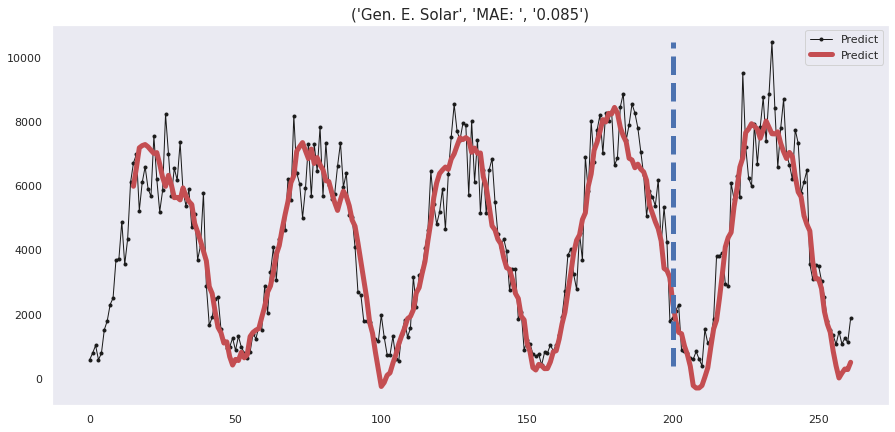

In [ ]:
y1_m1 = scaler.inverse_transform([[v] for v in y1_scaled_m1])
y1_m1 = [v[0]for v in y1_m1]

plt.figure(figsize=(15,7))
plt.plot(ys1_array, ".-k",linewidth=1,label='Predict')

plt.grid()

plt.title(('Gen. E. Solar', 'MAE: ', str(round(error_RNN_S,3))), loc = 'center', size=15)
plt.plot([None]*P + y1_m1, "-r", linewidth=5, label='Predict')
plt.plot([len(ys1_array)-62, len(ys1_array)-62], [min(ys1_array),max(ys1_array)], "--", linewidth=5)
plt.legend()

##Comparacion de MAE

In [ ]:
datos = [[error_lineal, error_lineal_solar],
         [Lasso_loss_w, Lasso_loss_s],
         [error_ridge_w, error_ridge_s],
         [error_en_w, error_en_s],
         [error_RNN_W, error_RNN_S]]

columnas = ['Er.Gen.E.Eólica', 'Er.Gen.E.Solar'] # definimos los nombres de las columnas
filas = ['Linear Model MAE', 'Lasso MAE', 'Ridge MAE', 'Elastic Net MAE', 'RNN MLP'] # definimos los nombres de las filas

df = pd.DataFrame(datos, columns=columnas, index=filas )

print(df)

                  Er.Gen.E.Eólica  Er.Gen.E.Solar
Linear Model MAE         0.702161        0.131684
Lasso MAE                0.733940        0.114972
Ridge MAE                0.702159        0.131657
Elastic Net MAE          0.770224        0.113185
RNN MLP                  0.139217        0.085336


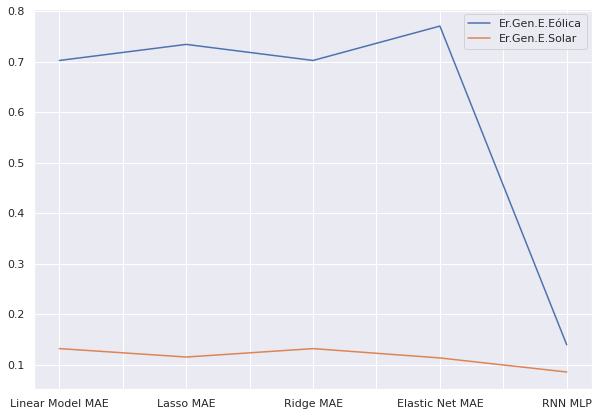

In [ ]:
df.plot(figsize=(10,7))

Con base al error absoluto medio obtenido de los resultados de cada modelo, concluimos que el modelo que mejor de adapta al problema es el perceptron multicapa MLPRegresor, tanto para la prediccion de generacion energetica solar como para la eólica donde tuvo una gran mejoria en la prediccion.

El siguiente modelo que mejor se desempeñó fue el Elastic Net para la generacion de energía solar, y para la generacion eólica el siguiente mejor modelo fue Ridge (aunque con un importante error). 

In [ ]:
!pip install jupyter-dash -q 

     |████████████████████████████████| 9.8 MB 9.5 MB/s 
     |████████████████████████████████| 357 kB 41.8 MB/s 


In [ ]:
from jupyter_dash import JupyterDash  # pip install dash
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input # Entradas y salidas para las graficas interactivas
import plotly.express as px
import plotly.graph_objects as go
from dash import no_update
import pandas as pd  #

external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"] # Plantilla estilo CSS

df = px.data.iris()  # Base de datos iris obtenida desde plotly.espress

app = JupyterDash(
    __name__, external_stylesheets=external_stylesheets
)  # Crear objeto JupyterDash para visualización en el entorno
# Crear un layout para contener el texto y gráficas.
# Crea Div para separar secciones, no tiene ningún efecto sobre el contenido o el diseño hasta que se le aplica estilo usando CSS.
app.layout = html.Div(
    children=[
        html.H1( # Componente Html para crear título
            children="Analítica de Datos - Predicción de energía renovable", # Texto título
            style={ # Diccionario definir estilo
                "textAlign": "center",
                "color": "#0D6080",
            },  # La función style nos permite personalizar la estética del documento
        ),  # Creación del título(Encabezado)

        html.P( # Componente Html para crear parrafo 
            children=[ # Texto parrafo
                """
                Pr. Andres Marino Alvarez Meza, Integrantes: Leonar Santiago Castro Vizcaya | Duvan Stiven Cruz Romero | Juan Jose Beltran Gonzales 
                """
            ],
            style={"textAlign": "center", "color": "#004D38"},# Diccionario definir estilo
        ),  # Creacion Parrafo 
        dcc.Markdown(
            children=[ 
                """
                El modelo del perceptron multicapa fue el que mejor desempeño tuvo obteniendose el minimo valor de error absoluto medio:
                Se observa un comportamiento 'ciclico' en que las mayores generaciones de energia son en temporoda de verano, lo que tiene todo el sentido dadas las altas temperaturas y la mayor presencia del sol.
                """
            ],
            style={"textAlign": "center", "color": "#000000"},
        ),  # Implementación de texto con Markdown
# De la línea 46 a la 143 se muestra una comparativa de diferentes tipos de gráficas creadas con las dos funciones vistas
        html.Div(
            [
                html.H2(
                    children="Gráfica con -modelo- para la predicción de energía solar",  # Crear subtitulo(los encabezados reduciran su tamaño al aumentar el numero al lado del H)
                    style={
                        "textAlign": "center",
                        "color": "#0D6080",
                    },  # La función style nos permite personalizar la estética del documento
                ),  # Creación del subtítulo (Encabezado)
                html.P(
                    children=[
                        "",
                        html.Br(),
                        html.A(
                            "",  # links ejemplos gráficas plotly.graph_objects
                            href="",
                        ),
                    ],
                    style={"textAlign": "center", "color": "#000000"},
                ),  # Creación Párrafo
                dcc.Graph(  # Sección Grafica
                    id="example-graph",  # id Gráfica
                    figure=go.Figure(data=[  # Gráfica barras tipo Go
                          go.Line(y=data_scaled, name='Original'), 
                          go.Line(y=[None] * P + y1_scaled_m1.tolist(), name='Predict')], 
                          layout=go.Layout(title="Gen. Solar")),
                ),
             


                html.H2(
                    children="Gráfica con -modelo- para la predicción de energía eólica",
                    style={
                        "textAlign": "center",
                        "color": "#0D6080",
                    },  # La función style nos permite personalizar la estetica del documento
                ),  # Creción del título(Encabezado)
                html.P(
                    children=[
                        "",
                        html.Br(),
                        html.A(
                            "",  # links ejemplos gráficas plotly.graph_objects
                            href="",
                        ),
                    ],
                    style={"textAlign": "center", "color": "#000000"},
                ),  # Creacion Parrafo
                dcc.Graph(   # Sección Grafica
                    id="example-graph9",  # id Gráfica
                    figure=go.Figure(data=[  # Gráfica barras tipo Go
                          go.Line(y=ys_array, name='Original'), 
                          go.Line(y=[None]*P + y_m1, name='Predict')], 
                          layout=go.Layout(title="Gen. Eolica")),
                ),  
                
            ],
            style={"columnCount": 1},
        ),  # Estilo 2 columnas
    ]
)


app.run_server(mode="inline", port=8050) # Ejecutar el Dash

# 636EFB violeta graf 
# EF553B naranja graf
# 00CD95 verde graf
# 004D38 Verde cool

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<IPython.core.display.Javascript object>